In [1]:
import pyspark.sql.functions as F
import pyspark.sql.types as T

spark = SparkSession\
        .builder\
        .appName("CalculatePrimeNumbers")\
        .getOrCreate()

In [2]:
MAX_VALUE = 1000000000

In [3]:
# Algorithm reference:
#	https://en.wikipedia.org/wiki/Primality_test

def isPrime(val):
    if val <= 3:
        return val > 1
    elif val%2 == 0 or val%3 == 0:
        return False
    else:
        i = 5
        while i*i < val:
            if val%i == 0 or val%(i + 2) == 0:
                return False
            i += 6
    return True

values = spark.sparkContext.parallelize(
        range(1,MAX_VALUE+1), 
        5000
    ).map(
        lambda x: (x, isPrime(x))
    ).toDF().withColumnRenamed('_1', 'value').withColumnRenamed('_2', 'is_prime').cache()


In [4]:
values.count()

1000000000

In [5]:
values.repartition(100).write.parquet('qfs:///test/prime-numbers', mode='overwrite')

In [6]:
df = spark.read.parquet('qfs:///test/prime-numbers')

In [7]:
df.count()

1000000000

In [8]:
df.filter(F.col('is_prime')).count()

50849242

In [9]:
df.filter(F.col('is_prime')).agg(F.max('value').alias('max_prime')).collect()[0].max_prime

999999937

In [32]:
# display a graph showing the density of prime numbers for every bucket of 1 million
#
# first, get the bucket rates

bucket_rates = (
    df
    .withColumn('bucket', F.floor( F.col('value')/1000000))
    .groupBy('bucket')
    .agg(
        F.sum(F.when(F.col('is_prime'),F.lit(1)).otherwise(F.lit(0))).alias('count_primes'),
        F.count('*').alias('items_in_bucket')
    )
    .withColumn(
        'prime_rate',
        F.col('count_primes').cast(T.DoubleType())/F.col('items_in_bucket').cast(T.DoubleType())
    )   
)

data = (
    bucket_rates
    .select('bucket', 'prime_rate')
    .withColumn('bucket_value', F.col('bucket')*1000000)
    .orderBy(F.col('bucket'))
    .filter(F.col('bucket') < 1000)
    .toPandas()
)

data

,bucket,prime_rate,bucket_value
0,0,0.078584,0
1,1,0.070463,1000000
2,2,0.067906,2000000
3,3,0.066346,3000000
4,4,0.065381,4000000
...,...,...,...
995,995,0.048286,995000000
996,996,0.048380,996000000
997,997,0.048358,997000000
998,998,0.048441,998000000


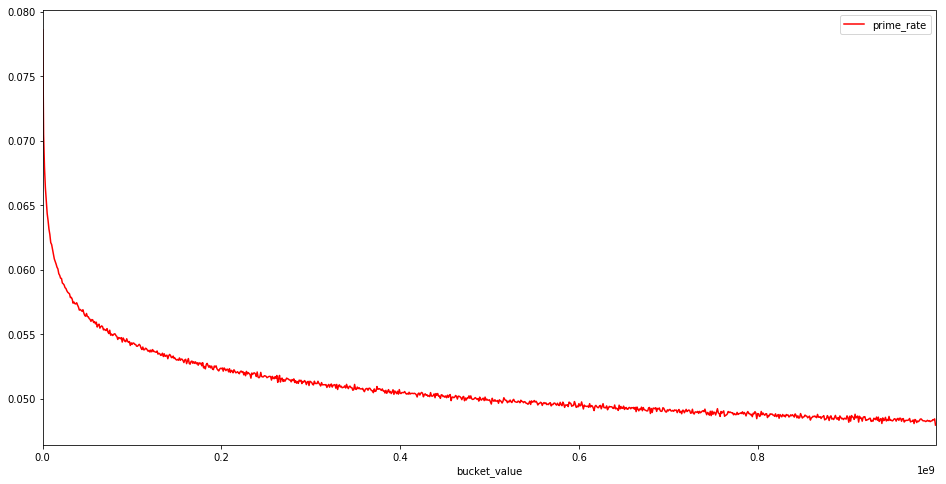

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

data.plot(kind='line',x='bucket_value',y='prime_rate',color='red', figsize=(16,8))
plt.show()